In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from google.colab import drive
from torchvision.transforms import transforms
from PIL import Image
import torchvision.models as models
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
torch.manual_seed(42)

In [3]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:

path = '/content/drive/My Drive/Dataset/FMNIST/fashion-mnist_train.csv'
df = pd.read_csv(path)
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


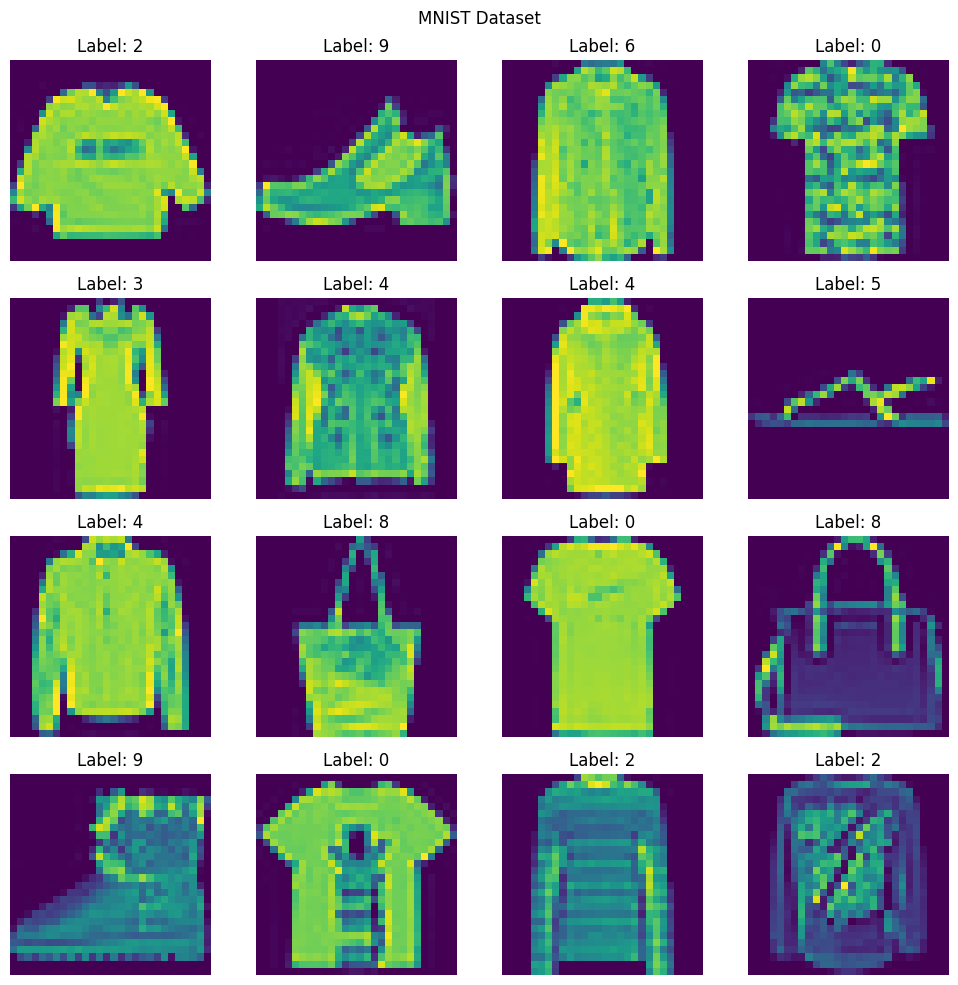

In [5]:
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle("MNIST Dataset")

for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}")
plt.tight_layout()
plt.show()

In [6]:
x_train,x_test,y_train,y_test=train_test_split(df.iloc[:,1:].values,df.iloc[:,0].values,test_size=0.2,random_state=42)

In [7]:
custom_transform=transforms.Compose([
    transforms.Resize(256,),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [8]:
class Custom_Dataset(Dataset):
  def __init__(self,features,labels,transforms):
    self.features=features
    self.labels=labels
    self.transforms=transforms

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    image=self.features[idx].reshape(28,28) #resize

    image=image.astype(np.uint8) #changing datatype

    image= np.stack([image]*3,axis=-1)  #colourizing

    image=Image.fromarray(image) #array to PIL Image

    image=self.transforms(image) #applying transforms

    return image,torch.tensor(self.labels[idx])

In [9]:
train_dataset=Custom_Dataset(x_train,y_train,custom_transform)
test_dataset=Custom_Dataset(x_test,y_test,custom_transform)

In [10]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [11]:
#fetching the pretrained library
vgg16=models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 76.9MB/s]


In [12]:
for param in vgg16.parameters(): # only in feature extraction part
  param.requires_grad=False

In [13]:
vgg16.classifier=nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(.4),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(.4),
    nn.Linear(512,10)
)
vgg16=vgg16.to(device )

In [14]:
learnrate=0.0001
epochs=10


In [15]:
lossFN=nn.CrossEntropyLoss()
optimizer=optim.Adam(vgg16.classifier.parameters(),lr=learnrate)

In [17]:
for epoch in range(epochs):

  Cost=0
  for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=vgg16(batch_features)

    current_loss=lossFN(outputs,batch_labels) # Use a different variable name for the calculated loss
    Cost+=current_loss.item()

    optimizer.zero_grad()

    current_loss.backward()

    optimizer.step()
  print(f"Epoch {epoch} : Loss {Cost/len(train_loader)}")

Epoch 0 : Loss 0.3063280944128831
Epoch 1 : Loss 0.194676412758107
Epoch 2 : Loss 0.14293294252175837
Epoch 3 : Loss 0.10591683556434388
Epoch 4 : Loss 0.0809314479191089
Epoch 5 : Loss 0.06105042535613757
Epoch 6 : Loss 0.04653817714333369
Epoch 7 : Loss 0.04010030353819214
Epoch 8 : Loss 0.033963241553223875
Epoch 9 : Loss 0.03131017635193651


In [18]:
total=0
correct=0

train_loader=DataLoader(train_dataset,batch_size=32,shuffle=False,pin_memory=True)
with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=vgg16(batch_features)

  _,predicted =torch.max(outputs,1)

  total+= batch_labels.shape[0]
  correct+=(predicted==batch_labels).sum().item()
  print(correct/total)

0.96875


In [19]:
total=0
correct=0
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)
with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features=batch_features.to(device)
    batch_labels=batch_labels.to(device)
    outputs=vgg16(batch_features)

    _,predicted =torch.max(outputs,1)

    total+= batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()
  print(correct/total)


0.9209166666666667


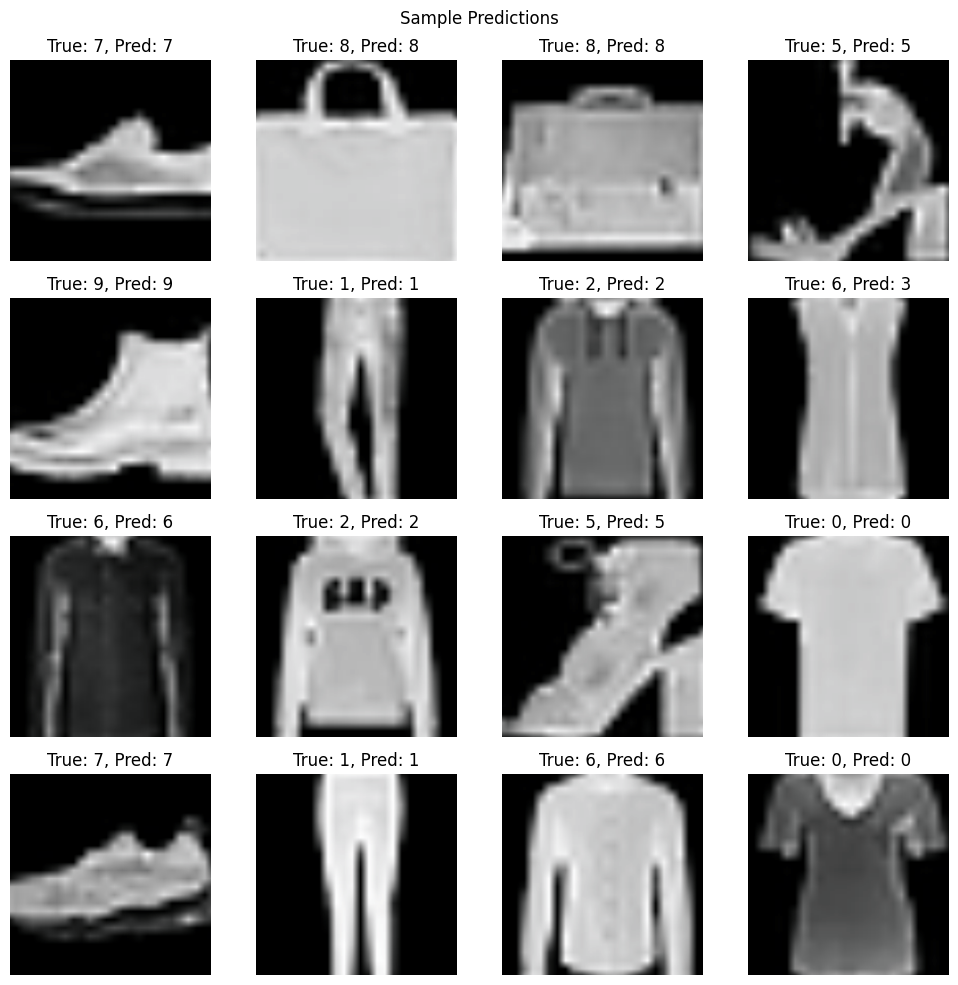

In [20]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Sample Predictions")

with torch.no_grad():
  for i, ax in enumerate(axes.flat):
    if i >= len(test_dataset):
      break
    image, true_label = test_dataset[i]
    image_display = image.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_display = std * image_display + mean
    image_display = np.clip(image_display, 0, 1)
    image_display = (image_display * 255).astype(np.uint8)
    image_input = image.unsqueeze(0).to(device)
    output = vgg16(image_input)
    _, predicted_label = torch.max(output, 1)

    ax.imshow(image_display)
    ax.axis('off')
    ax.set_title(f"True: {true_label.item()}, Pred: {predicted_label.item()}")

plt.tight_layout()
plt.show()